# Índice.
## Asignatura 06 - MBIG - Universidad internacional de Valencia
### Manuel Rentero García  -  AG1
### Análisis exploratorio de los datos - ML no supervisado

En este cuaderno realizaremos la primera actividad guiada de la asignatura de Machine Learning. Para ello utilizaremos los datos pertenecientes a la competición que encontramos en este link: [link.](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/)

La competición se pide predecir el número de casos semanales en las ciudades de San Juan, Puerto Rico, Iquitos y Peru (solo trabajaremos con Iquitos y San Juan). Para ello nos basaremos en una serie de medidas ambientales. Aunque la relación que guarda las variables medioambientales con la distribución de mosquitos es compleja, cada vez más científicos piensan que el cambio climático puede producir un desplazamiento en la distribución de mosquitos.

### Características de los datos

<ul>
  <li> <b>city</b> --> City abbreviations: sj for San Juan and iq for Iquitos </li>
  <li><b>week_start_date</b> --> Date given in yyyy-mm-dd format</li>
  <li><b>station_max_temp_c</b> --> Maximum temperature </li>
  <li><b>station_min_temp_c</b> --> Minimum temperature </li>
  <li><b>station_avg_temp_c</b> -->  Average temperature</li>
  <li><b>station_precip_mm</b> --> Total precipitation</li>
  <li><b>station_diur_temp_rng_c</b> --> Diurnal temperature range</li>
  <li><b>precipitation_amt_mm</b> --> Total precipitation</li>
  <li><b>reanalysis_sat_precip_amt_mm</b> --> Total precipitation</li>
  <li><b>reanalysis_dew_point_temp_k</b> --> Mean dew point temperature</li>
  <li><b>reanalysis_air_temp_k</b> --> Mean air temperature</li>
  <li><b>reanalysis_relative_humidity_percent</b> --> Mean relative humidity</li>
  <li><b>reanalysis_specific_humidity_g_per_kg</b> --> Mean specific humidity</li>
  <li><b>reanalysis_precip_amt_kg_per_m2</b> --> Total precipitation</li>
  <li><b>reanalysis_max_air_temp_k</b> --> Maximum air temperature</li>
  <li><b>reanalysis_min_air_temp_k</b> --> Minimum air temperature</li>
  <li><b>reanalysis_avg_temp_k</b> --> Average air temperature</li>
  <li><b>reanalysis_tdtr_k</b> --> Diurnal temperature range</li>
  <li><b>ndvi_se</b> --> Pixel southeast of city centroid</li>
  <li><b>ndvi_sw</b> --> Pixel southwest of city centroid</li>
  <li><b>ndvi_ne</b> --> Pixel northeast of city centroid</li>
  <li><b>ndvi_nw</b> --> Pixel northwest of city centroid</li>

</ul>



# Importación de módulos.
Cargamos todos los módulos que vamos a necesitar

In [ ]:
# Para cagar los datos
import pandas as pd
import io
from google.colab import files
# Para manipulas y visualizar los datos
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns

# Importación de los datos.
Cargamos los datos a Google Colab usando un snippet

In [ ]:
# Snippet de google Colab
def upload_files (index_fields):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)
    return df

Cargamos los datos de entrenamiento no etiquetados (dengue_features_train) y elegimos como índices la ciudad, la semana del año y el año.

In [ ]:
# df indexes --> {'city', 'weekofyear', 'year'}
data_train = upload_files(['city', 'weekofyear', 'year'])
data_train.head()

Saving dengue_features_train.csv to dengue_features_train.csv
User uploaded file "dengue_features_train.csv" with length 287139 bytes


week_start_date  ...  station_precip_mm
city weekofyear year                  ...                   
sj   18         1990      1990-04-30  ...               16.0
     19         1990      1990-05-07  ...                8.6
     20         1990      1990-05-14  ...               41.4
     21         1990      1990-05-21  ...                4.0
     22         1990      1990-05-28  ...                5.8

[5 rows x 21 columns]

Antes de preprocesar los datos vamos a ver información general de los datos importados.



In [ ]:
data_train.shape

(1456, 21)

El tipo de los datos contenido en el dataframe

In [ ]:
data_train.dtypes

week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rng_c                  float64
station_max_temp_c                       float64
station_min_temp_c                       float64
station_precip_mm   

Algunas estadísitcas básicas sobre estos datos

In [ ]:
data_train.describe()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1443.000000,1446.000000,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000
mean,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,299.225578,295.246356,303.427109,295.719156,40.151819,82.161959,45.760388,16.746427,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360
std,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,1.261715,1.527810,3.234601,2.565364,43.434399,7.153897,43.715537,1.542494,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314
min,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,297.800000,286.900000,0.000000,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000
25%,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,298.257143,294.118929,301.000000,293.900000,13.055000,77.177143,9.800000,15.557143,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000
50%,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,299.289286,295.640714,302.400000,296.200000,27.245000,80.301429,38.340000,17.087143,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000
75%,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,300.207143,296.460000,305.500000,297.900000,52.200000,86.357857,70.235000,17.978214,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000
max,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,314.000000,299.900000,570.500000,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000


Salvo la primera caracterísitca, el resto de los datos pertenecen a caresterísticas numéricas asociadas con factores climáticos. Los datos para cada característica presentan rangos y varianzas distintas. En el preprocesamiento realizaremos un escalado para evitar problemas con la ejecución de los algorimtos.

# Preprocesamiento.


## Eliminar datos redundantes
Antes de trabajar con los datos vamos a realizar un preproceso de los mismos.

En primer lugar eliminamos la columna week_start_day ya que disponemos de ese dato en el índice.

In [ ]:
data_train.drop("week_start_date", axis = 1, inplace= True)
data_train.head()

ndvi_ne   ndvi_nw  ...  station_min_temp_c  station_precip_mm
city weekofyear year                      ...                                       
sj   18         1990  0.122600  0.103725  ...                20.0               16.0
     19         1990  0.169900  0.142175  ...                22.2                8.6
     20         1990  0.032250  0.172967  ...                22.8               41.4
     21         1990  0.128633  0.245067  ...                23.3                4.0
     22         1990  0.196200  0.262200  ...                23.9                5.8

[5 rows x 20 columns]

## Procesar datos faltantes
En primer lugar vamos a comprobar si hay valores faltantes en el dataframe y para qué características faltan valores.

In [ ]:
data_train.isnull().any()

ndvi_ne                                  True
ndvi_nw                                  True
ndvi_se                                  True
ndvi_sw                                  True
precipitation_amt_mm                     True
reanalysis_air_temp_k                    True
reanalysis_avg_temp_k                    True
reanalysis_dew_point_temp_k              True
reanalysis_max_air_temp_k                True
reanalysis_min_air_temp_k                True
reanalysis_precip_amt_kg_per_m2          True
reanalysis_relative_humidity_percent     True
reanalysis_sat_precip_amt_mm             True
reanalysis_specific_humidity_g_per_kg    True
reanalysis_tdtr_k                        True
station_avg_temp_c                       True
station_diur_temp_rng_c                  True
station_max_temp_c                       True
station_min_temp_c                       True
station_precip_mm                        True
dtype: bool

Como podemos observar en todas las características nos encontramos con datos faltantes. Podemos usar métodos de relleno, de interpolación o de imputación de datos. En este caso voy a utilizar interpolación de datos. El parámetro *method* solo soporta 'lineal' si trabajamos con un dataframe de índices múltiples como es este caso.

In [ ]:
data_train.interpolate(method = "linear", inplace = True)
data_train.isnull().any()

ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_temp_c                       False
station_precip_mm                        False
dtype: bool

## Estandarización de los datos

Ajustaremos los rangos de cada característica para que en los algoritmos la varianza de ninguna de ellas predomine sobre el resto de características. Vamos a usar el paquete *preprocessing* de *sklearn* cuya clase *StandardScaler* que nos permite estandarizar los valores. Lo usaremos ya que a la hora de realizar el análisis de componenetes principales (PCA) que requiere del centrado de los datos en la media [(documentación)](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling).

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaled_train_data = scaler.fit_transform(data_train)  # Devuelve un array
print(scaled_train_data)

[[-0.06478633 -0.20175874 -0.06300293 ... -1.55559137 -1.33634635
  -0.49423653]
 [ 0.27990275  0.12016743 -0.55280903 ... -0.38117372  0.06494169
  -0.65078581]
 [-0.72319349  0.37797377 -0.62273    ... -0.12586553  0.44711115
   0.0431083 ]
 ...
 [ 0.84216934  0.15267067  0.64031221 ... -0.12586553 -1.84590563
  -0.67617218]
 [ 1.47512342  0.98753783  1.02710856 ... -0.6364819  -0.69939724
  -0.49423653]
 [ 1.21475856  0.88036865  0.96377281 ...  0.64005902  0.06494169
  -0.40115317]]


In [ ]:
# Convertimos el array a dataframe 
scaled_train_df = pd.DataFrame(scaled_train_data, index = data_train.index ,columns = data_train.columns)
scaled_train_df

ndvi_ne   ndvi_nw  ...  station_min_temp_c  station_precip_mm
city weekofyear year                      ...                                       
sj   18         1990 -0.064786 -0.201759  ...           -1.336346          -0.494237
     19         1990  0.279903  0.120167  ...            0.064942          -0.650786
     20         1990 -0.723193  0.377974  ...            0.447111           0.043108
     21         1990 -0.020820  0.981638  ...            0.765586          -0.748100
     22         1990  0.471559  1.125088  ...            1.147755          -0.710021
...                        ...       ...  ...                 ...                ...
iq   21         2010  1.539512  1.599814  ...            0.192332          -0.261528
     22         2010  0.208903  0.272518  ...           -0.253533          -0.058437
     23         2010  0.842169  0.152671  ...           -1.845906          -0.676172
     24         2010  1.475123  0.987538  ...           -0.699397          -0.494237
     25         2010  1.214759  0.880369  ...            0.064942          -0.401153

[1456 rows x 20 columns]

A continuación se muestran los datos escalados. Se puede apreciar que la media se encuentra en 0 y la desviación estándar es muy próxima a la unidad.

In [ ]:
scaled_train_df.describe()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03,1.456000e+03
mean,3.548749e-16,4.681847e-17,3.939157e-16,-2.437001e-16,-8.429612e-17,-2.299023e-15,1.739840e-14,-1.811246e-14,-6.857305e-15,-2.103934e-15,-2.317953e-16,5.283472e-16,-8.429612e-17,-1.127761e-16,-2.141144e-16,4.457896e-15,-5.474864e-17,-1.755769e-15,-8.016710e-16,-3.303219e-16
std,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00,1.000344e+00
min,-3.918673e+00,-4.888945e+00,-2.964682e+00,-3.180119e+00,-1.047340e+00,-2.988084e+00,-3.435741e+00,-3.672207e+00,-1.738887e+00,-3.447220e+00,-9.267257e-01,-3.410738e+00,-1.047340e+00,-3.264640e+00,-1.000545e+00,-4.514363e+00,-1.677144e+00,-2.934256e+00,-4.712177e+00,-8.327215e-01
25%,-6.856639e-01,-6.675539e-01,-6.653410e-01,-6.890297e-01,-8.231000e-01,-7.649583e-01,-7.655695e-01,-7.386095e-01,-7.488014e-01,-7.108473e-01,-6.218635e-01,-6.960512e-01,-8.231000e-01,-7.725228e-01,-7.262500e-01,-6.771049e-01,-7.367597e-01,-6.875435e-01,-6.357023e-01,-6.454970e-01
50%,-1.161618e-01,-9.960307e-02,-1.012242e-01,-1.418761e-01,-1.691729e-01,-4.248177e-02,5.078877e-02,2.582984e-01,-3.156388e-01,1.882464e-01,-2.962151e-01,-2.636674e-01,-1.691729e-01,2.204754e-01,-5.770011e-01,1.706615e-01,-3.505305e-01,1.805043e-01,6.494169e-02,-3.239363e-01
75%,7.283813e-01,7.167443e-01,6.010423e-01,5.345631e-01,5.620406e-01,8.310581e-01,7.821097e-01,7.953831e-01,6.435070e-01,8.527940e-01,2.788660e-01,5.964546e-01,5.620406e-01,7.993960e-01,7.712806e-01,7.413003e-01,7.090808e-01,7.421823e-01,7.655857e-01,3.075497e-01
max,2.746340e+00,2.734539e+00,4.544492e+00,4.122270e+00,7.903910e+00,2.576299e+00,2.942058e+00,2.101337e+00,3.273423e+00,1.634615e+00,1.224933e+01,2.298966e+00,7.903910e+00,2.412815e+00,3.142119e+00,2.825509e+00,3.622592e+00,4.980298e+00,2.230569e+00,1.066096e+01


# Análisis de componenetes principales (PCA)

Esta es una técnica de reducción de la dimensionalidad que se basa en la obtención de un nuevo conjunto de variables que son combinación lineal de las anteriores. 

Los pasos del algoritmo son:

* Se estandarizan los datos de entrada
* Se obtienen los autovalores y autovectores de la matriz de covarianza
* Se ordenan los autovalores de menor a mayor y se eligen los 'k' autovectores correspondientes a los 'k' autovalores más grandes. Donde 'k' es la nueva dimensión del subespacio vectorial.
* Con los nuevos autovectores se forma la matriz de proyección W
* Cada vector se transforma aplicandole la matriz de transformación


Vamos a elegir en primer lugar un número arbitrario de caracterísitcas del nuevo subespacio y vamos a ver como cambia la varianza explicada.

In [ ]:
from sklearn.decomposition import PCA
# Usamos 3 dimensiones de forma arbitraria en la PCA
pca = PCA(n_components = 3)
pca.fit(scaled_train_data)  # Obtenemos las componentes principales
pca_train_data = pca.transform(scaled_train_data) # Transformamos nuestros datos

print("Varianza explicada por cada componente: \n", pca.explained_variance_ratio_)
print("Número de componentes en el estimador: \n", pca.components_.shape)


Varianza explicada por cada componente: 
 [0.35400047 0.26517914 0.13460075]
Número de componentes en el estimador: 
 (3, 20)


In [ ]:
pca_train_data.shape

(1456, 3)

Como se observa la primera componente explica un 35 % de la varianza total. Si mostramos la función cumulativa de las varianzas explicadas por las componentes, se puede observar que para las tres primeras componentes se obtiene alrededor del 75 % y 80 % de la varianza total explicada

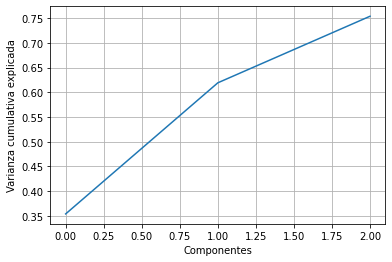

In [ ]:
# Hacemos un gráfico de la varianza explicada vs nº de componentes
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Componentes")
plt.ylabel("Varianza cumulativa explicada")
plt.grid()

Tomaremos las tres primeras componentes. Vamos a trasladar la transformación PCA a un dataframe en donde compararemos las características iniciales con cada componente del PCA

Como se puede ver es difícil nombrar las características en un gráfico. Vamos a crear un objeto multi-index para así poder identificar las características con un número

In [ ]:
# creamos dataframe
X_pca = pd.DataFrame(np.matrix.transpose(pca.components_[:3,:]), index = scaled_train_df.columns, columns = ["PC-1", "PC-2", "PC-3"])

# añadimos una columna de números
X_pca[""] = np.arange(0,20)

# los convertimos en el índice junto con las variables
X_pca.set_index(["",scaled_train_df.columns], inplace = True)
X_pca

,,PC-1,PC-2,PC-3
,,,,
0,ndvi_ne,0.299854,0.108596,-0.067095
1,ndvi_nw,0.293658,0.103968,-0.074226
2,ndvi_se,0.222441,0.099785,-0.157494
3,ndvi_sw,0.258260,0.106708,-0.136526
4,precipitation_amt_mm,0.183648,-0.141111,0.375957
5,reanalysis_air_temp_k,-0.080272,-0.356502,-0.264384
6,reanalysis_avg_temp_k,0.064958,-0.335990,-0.307310
7,reanalysis_dew_point_temp_k,0.130473,-0.377352,0.093447
8,reanalysis_max_air_temp_k,0.328611,-0.016412,-0.183445




Lo que vemos aquí son los valores de los [*Loadings*](http://www.statistics4u.com/fundstat_eng/cc_pca_loadscore.html). Como se observa, la componente principal PC1 viene explicada por casi todas las características, sin embargo, la componente PC2 viene explicada por menos características.

Video explicativo: [link](https://www.youtube.com/watch?v=eJ08Gdl5LH0&t=303s)

Los datos proyectados sobre las componentes PC1 y PC2 quedan:

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'PC2')

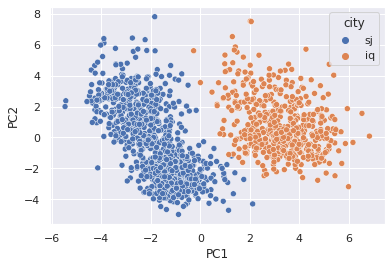

In [ ]:
# Divido los datos en función de la ciudad

# Voy a crear un dataframe transitorio en el que quito del índice la ciudad
# para usarla como clase en el plot
city_index_drop = data_train.reset_index(level=[0])

# Gráfico de los datos proyectados en la PCA
sns.set_theme()
sns.scatterplot(pca_train_data[:,0], pca_train_data[:,1],hue=city_index_drop["city"])

plt.xlabel("PC1")
plt.ylabel("PC2")





Como se puede ver la primera componente principal separa bastante bien los datos proyectados en dos grupos. Hasta aquí lo que puedo interpretar es que al producirse esta separación en el eje PC1 y estar esta componente explicada, en general, por casi todas las características, los datos medioambientales para ambas ciudades difieren. 

# Selección de características

En este apartado vamos a ver qué caracteristicas se correlacionan más para reducir el número de ellas e intentando perder la menor información posible

In [ ]:
# Transpuesta de la matriz para tener las características en el índice
data_t = data_train.T
data_t

city                                           sj  ...          iq
weekofyear                                     18  ...          25
year                                         1990  ...        2010
ndvi_ne                                  0.122600  ...    0.298186
ndvi_nw                                  0.103725  ...    0.232971
ndvi_se                                  0.198483  ...    0.274214
ndvi_sw                                  0.177617  ...    0.315757
precipitation_amt_mm                    12.420000  ...   63.220000
reanalysis_air_temp_k                  297.572857  ...  298.097143
reanalysis_avg_temp_k                  297.742857  ...  299.835714
reanalysis_dew_point_temp_k            292.414286  ...  295.807143
reanalysis_max_air_temp_k              299.800000  ...  307.800000
reanalysis_min_air_temp_k              295.900000  ...  292.300000
reanalysis_precip_amt_kg_per_m2         32.000000  ...   36.900000
reanalysis_relative_humidity_percent    73.365714  ...   89.082857
reanalysis_sat_precip_amt_mm            12.420000  ...   63.220000
reanalysis_specific_humidity_g_per_kg   14.012857  ...   17.355714
reanalysis_tdtr_k                        2.628571  ...   11.014286
station_avg_temp_c                      25.442857  ...   27.475000
station_diur_temp_rng_c                  6.900000  ...    9.900000
station_max_temp_c                      29.400000  ...   33.700000
station_min_temp_c                      20.000000  ...   22.200000
station_precip_mm                       16.000000  ...   20.400000

[20 rows x 1456 columns]

In [ ]:
# nombre de las características
names = data_t.index

## Correlación entre variables


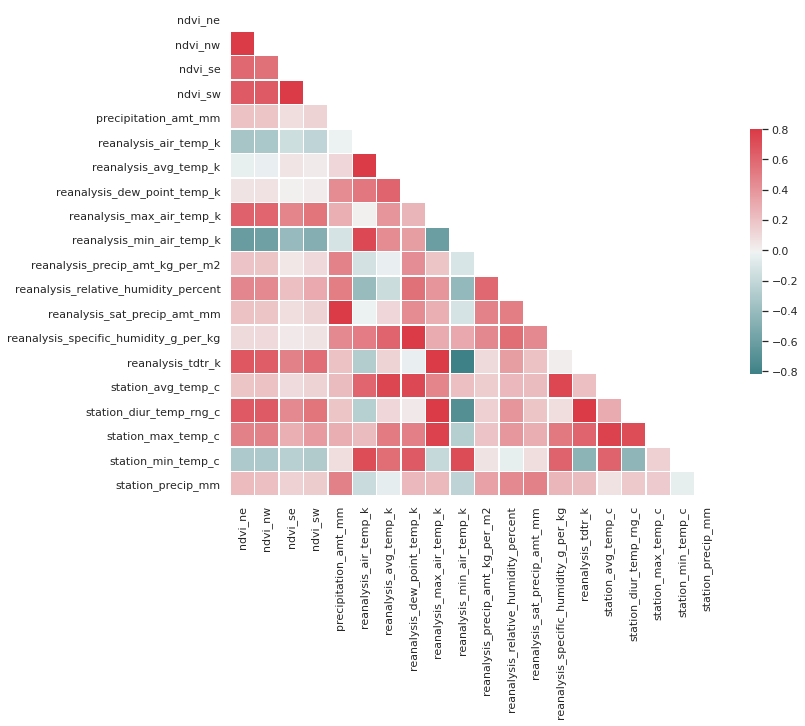

In [ ]:
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html
# Devuelve el coeficiente de correlación de Pearson
R = np.corrcoef(data_t)

# http://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
# Generate a mask for the upper triangle
sns.set(style="white")
mask = np.zeros_like(R, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(200, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(R, mask=mask, cmap=cmap, vmax=.8,
            square=True, xticklabels=names, yticklabels=names,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

Como se observa nos encontramos con variables correlacionadas positivamente y otras negativamente. Ninguna llega a la unidad de modo que continuamos con el análisis para seleccionar características.

## PCA sobre las características
Usaremos la PCA calculada anteriormente para ver como se relacionan las características.

In [ ]:
print("Varianza explicada por cada componente: \n", pca.explained_variance_ratio_)
X_pca # índices numéricos para referenciar características

Varianza explicada por cada componente: 
 [0.35400047 0.26517914 0.13460075]


,,PC-1,PC-2,PC-3
,,,,
0,ndvi_ne,0.299854,0.108596,-0.067095
1,ndvi_nw,0.293658,0.103968,-0.074226
2,ndvi_se,0.222441,0.099785,-0.157494
3,ndvi_sw,0.258260,0.106708,-0.136526
4,precipitation_amt_mm,0.183648,-0.141111,0.375957
5,reanalysis_air_temp_k,-0.080272,-0.356502,-0.264384
6,reanalysis_avg_temp_k,0.064958,-0.335990,-0.307310
7,reanalysis_dew_point_temp_k,0.130473,-0.377352,0.093447
8,reanalysis_max_air_temp_k,0.328611,-0.016412,-0.183445


Text(0, 0.5, 'PC2')

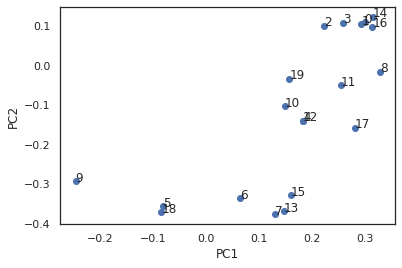

In [ ]:
# Vamos solo a usar los índices numéricos, quitamos el nombre de las características
tem_ind = X_pca.reset_index(level=[1]).index

# Gráfico de dispersión
plt.scatter(X_pca["PC-1"],X_pca["PC-2"])

# Etiquetamos cada variable por su número
for i in range(len(X_pca)):
    plt.text(X_pca["PC-1"][i], X_pca["PC-2"][i], tem_ind[i])

plt.xlabel("PC1")
plt.ylabel("PC2")

## Clustering jerárquico sobre características


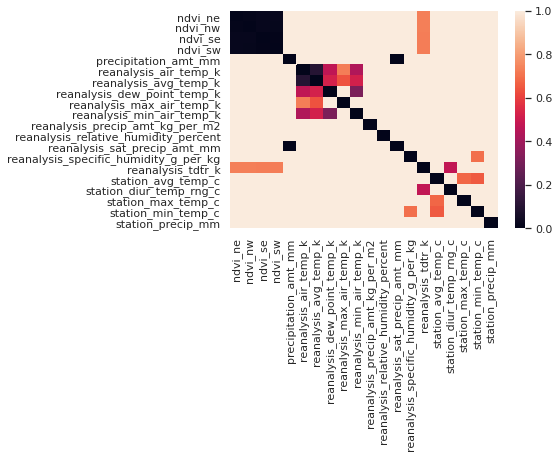

In [ ]:
# Realizamos la normalización de los datos a [0,1]
min_max_scaler = preprocessing.MinMaxScaler()
data_norm = min_max_scaler.fit_transform(data_train.T)

# calculamos la matriz de similitud
import sklearn.neighbors
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
matdist= dist.pairwise(data_norm)

# Mostramos mapa de temperatura
ax = sns.heatmap(matdist,vmin=0, vmax=1, yticklabels = names, xticklabels = names)

Según la matriz de similitudes hay un conjunto de variables que se parecen entre sí, sin embargo, la gran mayoría de las características presentan gran variabilidad. Parece que las variables que empiezan con ndvi también se encuentran muy próximas entre sí, sin embargo estas cuatro variables dan valores de píxeles del centroide de la ciudad y poco tienen que ver con el clima.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.


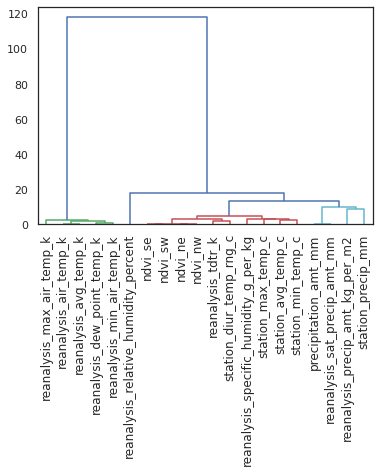

In [ ]:
# Construimos el dendograma	
# http://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage
from scipy import cluster
clusters = cluster.hierarchy.linkage(matdist, method = 'single')
# http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html
cluster.hierarchy.dendrogram(clusters, color_threshold =10 ,labels = names , leaf_rotation=90)
#plt.ylim(top = 10)
plt.show()

Vamos a asignar cada variable a un grupo con un corte ad-hoc. En el dendograma se aprecian tres grupos y un valor aislado *reanalysis_relative_humidity_percent*. Por otro lado, nos encontramos un grupo de características (verde) muy alejadas de las demás.

In [ ]:
cut = 10 # !!!! ad-hoc
labels = cluster.hierarchy.fcluster(clusters, cut , criterion = 'distance')

labels

array([2, 2, 2, 2, 3, 1, 1, 1, 1, 1, 3, 4, 3, 2, 2, 2, 2, 2, 2, 3],
      dtype=int32)

Text(0, 0.5, 'PC2')

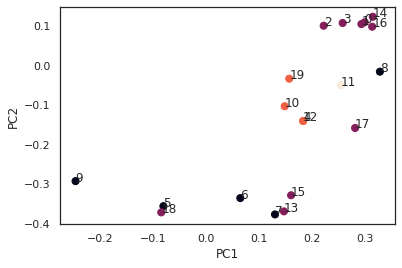

In [ ]:
plt.scatter(X_pca["PC-1"],X_pca["PC-2"], c= labels, s=50)
for i in range(len(X_pca)):
    plt.text(X_pca["PC-1"][i], X_pca["PC-2"][i], tem_ind[i]) 
plt.xlabel("PC1")
plt.ylabel("PC2")

Vemos que las varaibles en morado son los que mejor explican a la componenete uno y en parte a la componenete 2 (valores del fondo). La componente 11 parece que no se asocia con ningún clúster y se puede considerar como un outlier. Las varaibles en negro, correspondientes a la rama verde del dendograma, parecen encontrarse muy dispersas en cuanto a la variabilidad que explican de las componentes principales.

Desafortunadamente el valor para la varianza explicada por eje en la PCA no es muy bueno.


## DBSCAN sobre características

Usaremos el algoritmo de clústering DBSCAN para localizar posibles variables outliers. Establecemos el número mínimo de puntos a 4 para favorecer la detección de las variables más alejados.

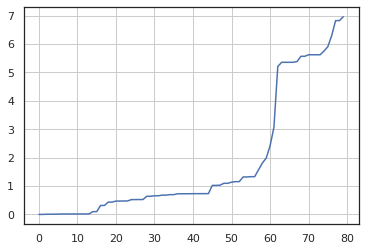

In [ ]:
from sklearn.neighbors import kneighbors_graph

#https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html
minPts = 4
A = kneighbors_graph(data_norm, minPts, include_self=False)
Ar = A.toarray()

seq = []
for i,s in enumerate(data_norm):
    for j in range(len(data_norm)):
        if Ar[i][j] != 0:
            seq.append(matdist[i][j]) 
            
seq.sort()
# establecer intervalo ejes
fig = plt.figure()
ax = fig.gca()
#ax.set_xticks(np.arange(0, 120, 10))
#ax.set_yticks(np.arange(0, 3, 0.2))

plt.plot(seq)
plt.grid()

plt.show()

Como vemos hay un salto brusco en la distancia a los vecinos próximos para rangos $\epsilon$ entre 1 y 6 aproximadamente. Tomamos un rango amplio de este parámetro para analizar el número de outliers que nos va surgiendo.

In [ ]:
from sklearn.cluster import DBSCAN

for eps in np.arange(1, 5.5, 0.5):
  db = DBSCAN(eps, min_samples=minPts).fit(data_norm)
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_outliers = list(labels).count(-1)
  print ("%6.2f, %d, %d" % (eps, n_clusters_, n_outliers))

  1.00, 2, 9
  1.50, 2, 5
  2.00, 2, 5
  2.50, 2, 5
  3.00, 2, 5
  3.50, 2, 5
  4.00, 2, 5
  4.50, 2, 5
  5.00, 2, 5


Nos quedaremos con la parametrización que más outliers nos da y para la cual tenemos dos grupos y nueve outliers.

In [ ]:
# label = -1 --> outlier
db = DBSCAN(eps=1, min_samples=minPts).fit(data_norm)
labels = db.labels_
labels

array([ 0,  0,  0,  0, -1,  1,  1,  1,  1,  1, -1, -1, -1, -1,  0, -1,  0,
       -1, -1, -1])

Text(0, 0.5, 'PC2')

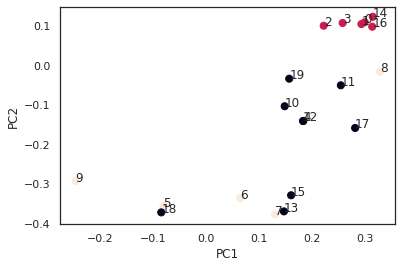

In [ ]:
# Graficamos los puntos y etiquetas asignadas
plt.scatter(X_pca["PC-1"],X_pca["PC-2"], c= labels, s=50)
for i in range(len(X_pca)):
    plt.text(X_pca["PC-1"][i], X_pca["PC-2"][i], tem_ind[i]) 
plt.xlabel("PC1")
plt.ylabel("PC2")

Vamos a proceder a identificar los elementos outliers

In [ ]:
data_t["dbscan_group"] = labels

data_t[data_t["dbscan_group"] == -1]

city                                          sj  ... dbscan_group
weekofyear                                    18  ...             
year                                        1990  ...             
precipitation_amt_mm                   12.420000  ...           -1
reanalysis_precip_amt_kg_per_m2        32.000000  ...           -1
reanalysis_relative_humidity_percent   73.365714  ...           -1
reanalysis_sat_precip_amt_mm           12.420000  ...           -1
reanalysis_specific_humidity_g_per_kg  14.012857  ...           -1
station_avg_temp_c                     25.442857  ...           -1
station_max_temp_c                     29.400000  ...           -1
station_min_temp_c                     20.000000  ...           -1
station_precip_mm                      16.000000  ...           -1

[9 rows x 1457 columns]

Ante los resultados del análisis de características vamos a seleccionar cuatro variables de forma argumentada. 

Seleccionaremos la variable 11 *reanalysis_relative_humidity_percent* correspondiente a la humedad relativa media. Esta variable es la que mayor tiende a ser outlier. La variable 12 *reanalysis_sat_precip_amt_mm* ya que se detectó como outlier en DBSCAN y dentro de su grupo en el clústering jerarquico es la que mejor viene explicada por la PCA. Por la mismas razones que para la variable anterior, seleccionamos la variable 15 *station_avg_temp_c* pero en este caso para las variables clasificadas en color morado en el clustering jerárquico. Seleccionamos también la variable 8 *reanalysis_max_air_temp_k* al ser catalogada en el grupo negro por el clústering jerárquico y por ser de las variables mejor representadas por la PC1.

In [ ]:
# Selección de características
features = ["reanalysis_relative_humidity_percent","reanalysis_sat_precip_amt_mm",
            "reanalysis_max_air_temp_k","station_avg_temp_c","group"]

# Clústering jerárquico de los registros

En primer lugar vamos a calcular la matriz de distancia entre las características del data set

In [ ]:
# Escalado de los datos a rango [0,1]
scaler = preprocessing.MinMaxScaler()
minmax_scaled_data = scaler.fit_transform(data_train)

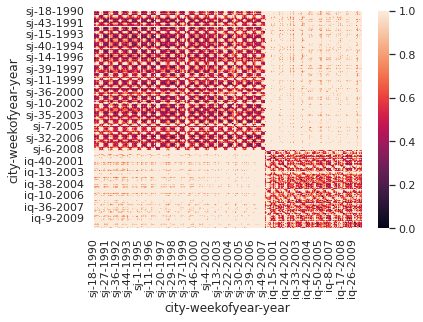

In [ ]:
#3. Hierarchical Clustering
# 3.1. Compute the similarity matrix
import sklearn.neighbors
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
matsim = dist.pairwise(minmax_scaled_data)

# Para ver los índices en la matriz de distancias creamos nuevo df
matsim_df = pd.DataFrame(matsim, index = data_train.index, columns= data_train.index)
sns.heatmap(matsim_df,vmin=0, vmax=1)

Al igual que nos pasaba con la PCA nos encontramos con dos estructuras de datos bien diferenciadas. Cada una pertenece a una ciudad. Por esta razón voy a analizar la estructura de los datos por separado para ambas ciudades.

A continuación renombraré ambas matrices de similitud para cada una de las ciudades. Empezamos con San Juan. Probando con el el dataframe encontramos que los datos pertenecientes a San Juan corersponden a las posiciones < 936, por esta razón en algunos fragmentos del código aparecerá [:936]

In [ ]:
# Matrices de similitud para cada una de las ciudades
# Nota: Muchas de las fechas no aparecen ya que sns.heatmap() tiene por defecto
# una keyword que evita el overlaping de los índices
matsim_sj = matsim_df.loc["sj"]["sj"]
matsim_iq = matsim_df.loc["iq"]["iq"]

## Datos de San Juan

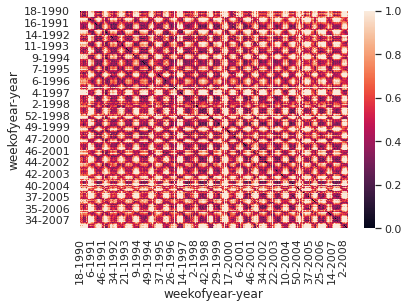

In [ ]:
# Heatmap de San Juan
sns.heatmap(matsim_sj,vmin=0, vmax=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


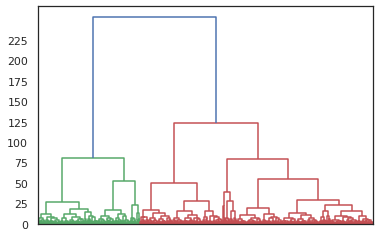

In [ ]:
# Construyendo el dendograma
from scipy import cluster
clusters_sj = cluster.hierarchy.linkage(matsim_sj, method = 'ward')
# http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html
cluster.hierarchy.dendrogram(clusters_sj, no_labels=True)

# Visualización de los datos

plt.yticks(np.arange(0,250,25))
plt.show()

#f.savefig( "test.png")
#files.download('test.png')

Debido a que el dendograma es muy denso se ha decidido eliminar las etiquetas

In [ ]:
cut = 100 # !!!! ad-hoc
labels_sj = cluster.hierarchy.fcluster(clusters_sj, cut , criterion = 'distance')

labels_sj

array([1, 2, 2, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 3, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 3, 3, 2,
       2, 2, 3, 3, 3, 3, 2, 2, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3,
       2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 2, 3, 3, 3, 2, 2,
       3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2,
       3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1,

In [ ]:
from sklearn import metrics
n_clusters_sj = len(set(labels_sj)) - (1 if -1 in labels_sj else 0)
print('Estimated number of clusters: %d' % n_clusters_sj)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(minmax_scaled_data[:936], labels_sj))

Estimated number of clusters: 3
Silhouette Coefficient: 0.218


El coeficiente obtenido es bastante bajo, aún así no se ha podido mejorar tras varias pruebas

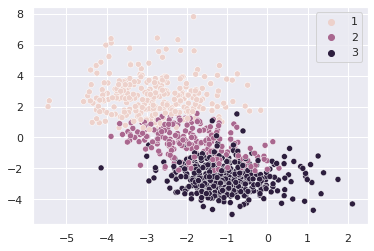

In [ ]:
# Gráfico de dispersión con los grupos como etiquetas
#fig, ax = plt.subplots()
#plt.scatter(pca_train_data[:936,0], pca_train_data[:936,1], c=labels_sj,s=50)
sns.set_theme()
sns.scatterplot(x = pca_train_data[:936,0], y = pca_train_data[:936,1], hue=labels_sj)
plt.legend()


Representamos la cantidad de cada una de las variables seleccionadas en los grupos obtenidos mediante un gráfico de barras.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


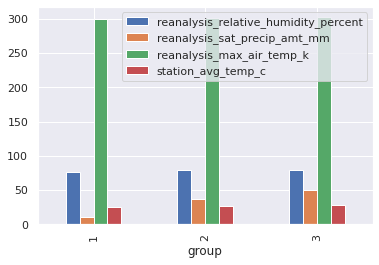

In [ ]:
# Gráfico de barras con las variables
data_train_sj = data_train.loc["sj"]
data_train_sj['group'] = labels_sj

res = data_train_sj.loc[:,np.array(features)].groupby(('group')).mean()
res.plot(kind='bar', legend=True)

Se puede ver los registros que hay en cada uno de los grupos, por ejemplo en el grupo 3

In [ ]:
data_train_sj[data_train_sj['group'] == 3]

,,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,group
weekofyear,year,,,,,,,,,,,,,,,,,,,,,
22,1990,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,3
23,1990,0.154550,0.174850,0.254314,0.181743,9.58,299.630000,299.764286,295.851429,302.4,298.1,26.49,79.891429,9.58,17.212857,2.100000,28.114286,6.942857,34.4,23.9,39.1,3
25,1990,0.072500,0.072500,0.151471,0.133029,151.12,299.591429,299.528571,296.531429,300.6,298.4,30.00,83.375714,151.12,17.977143,1.571429,28.371429,7.685714,33.9,22.8,21.1,3
26,1990,0.102450,0.146175,0.125571,0.123600,19.32,299.578571,299.557143,296.378571,302.1,297.7,37.51,82.768571,19.32,17.790000,1.885714,28.328571,7.385714,33.9,22.8,21.1,3
27,1990,0.147663,0.121550,0.160683,0.202567,14.41,300.154286,300.278571,296.651429,302.3,298.7,28.40,81.281429,14.41,18.071429,2.014286,28.328571,6.514286,33.9,24.4,1.1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,2007,0.096000,0.024767,0.185300,0.117729,74.50,301.022857,301.028571,296.642857,303.5,299.1,17.60,77.190000,74.50,18.118571,2.685714,27.985714,7.242857,32.8,22.2,86.6,3
41,2007,0.009000,0.104000,0.118129,0.126343,108.26,300.790000,300.942857,296.835714,302.9,299.3,21.98,79.178571,108.26,18.375714,3.000000,28.128571,6.914286,33.3,23.9,14.5,3
42,2007,0.021000,0.132667,0.245943,0.189757,17.56,301.492857,301.635714,296.354286,303.6,299.4,8.30,73.867143,17.56,17.845714,3.185714,29.100000,7.542857,33.9,24.4,10.2,3


Se muestran también algunos estadísticos sobre cada grupo

In [ ]:
data_train_sj[features].groupby('group').describe()

reanalysis_relative_humidity_percent             ... station_avg_temp_c           
                                     count       mean  ...                75%        max
group                                                  ...                              
1                                    286.0  75.893786  ...          25.871429  27.371429
2                                    232.0  79.534243  ...          27.346429  28.428571
3                                    418.0  79.863469  ...          28.628571  30.071429

[3 rows x 32 columns]

y un mapa de calor en el que se compara los dendogramas de variables y registros

/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


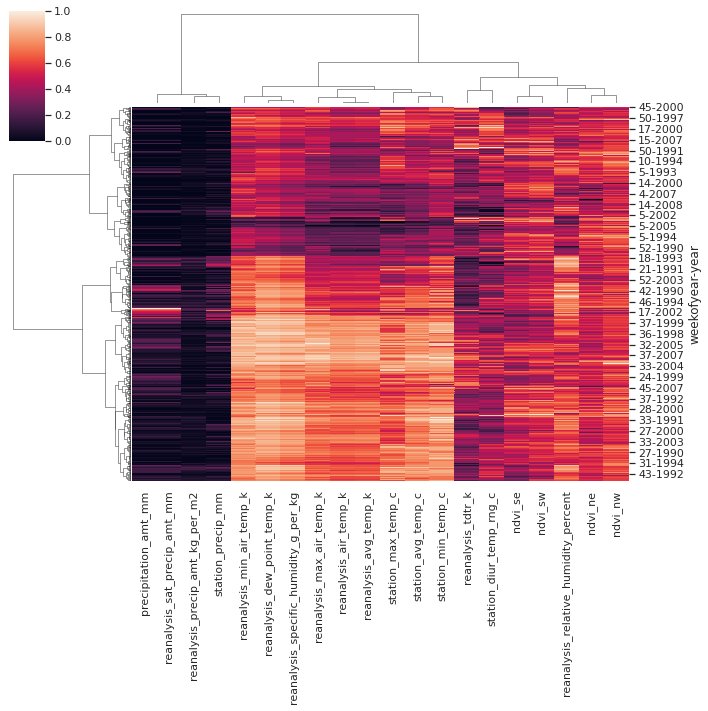

In [ ]:
# https://seaborn.pydata.org/generated/seaborn.clustermap.html
sns.set(color_codes=True)
sns.clustermap(data_train_sj.drop("group", axis = "columns"), standard_scale=1, method = "ward")

Realizamos los mismos pasos para los datos pertenecientes a la ciudad de iquitos. Probando con el el dataframe encontramos que los datos pertenecientes a Iquitos corersponden a las posiciones >=936, por esta razón en algunos fragmentos del código aparecerá [936:]

## Datos de Iquitos

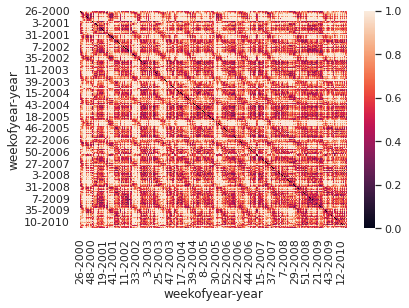

In [ ]:
# Heatmap de Iquitos
sns.heatmap(matsim_iq,vmin=0, vmax=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


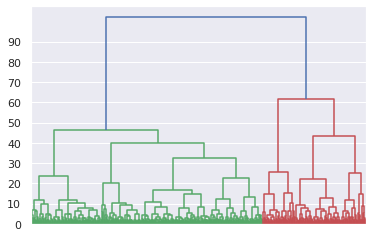

In [ ]:
# Construimos el dendograma
# http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html

from scipy import cluster
clusters_iq = cluster.hierarchy.linkage(matsim_iq, method = 'ward')
cluster.hierarchy.dendrogram(clusters_iq, no_labels=True)

# Visualización

plt.yticks(np.arange(0,100,10))
plt.show()

#f.savefig( "test.png")
#files.download('test.png')

Como vemos de nuevo hemos obtenido un dendograma muy denso debido al alto número de registros, por lo tanto se ha decidido quitar las etiquetas.

In [ ]:
cut = 50 # !!!! ad-hoc
labels_iq = cluster.hierarchy.fcluster(clusters_iq, cut , criterion = 'distance')

labels_iq

array([1, 1, 1, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 1, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 3, 2, 2, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1,
       1, 2, 2, 1, 2, 2, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 3, 2, 3, 3, 1, 1, 1,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3,
       2, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
from sklearn import metrics
n_clusters_iq = len(set(labels_iq)) - (1 if -1 in labels_iq else 0)
print('Estimated number of clusters: %d' % n_clusters_iq)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(minmax_scaled_data[936:], labels_iq))

Estimated number of clusters: 3
Silhouette Coefficient: 0.233


De nuevo no se obtiene muy buen coeficiente de silhouette

Mostramos el resultado del clustering jerárquico

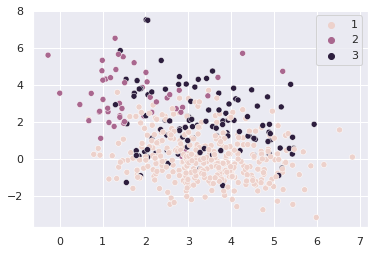

In [ ]:
# Gráfico de dispersión con los grupos como etiquetas
sns.scatterplot(x =pca_train_data[936:,0], y = pca_train_data[936:,1], hue=labels_iq)
plt.legend()

Representamos la cantidad de cada una de las variables seleccionadas en los grupos obtenidos mediante un gráfico de barras.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


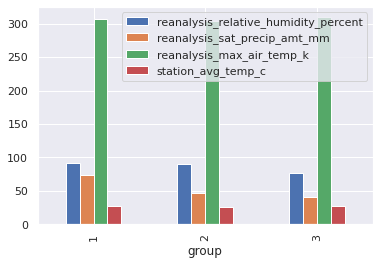

In [ ]:
# Gráfico de barras con las variables
data_train_iq = data_train.loc["iq"]
data_train_iq['group'] = labels_iq

res = data_train_iq.loc[:,np.array(features)].groupby(('group')).mean()
res.plot(kind='bar', legend=True)

Se puede obtener los registros de un grupo en particular ocmo los del grupo 2

In [ ]:
data_train_iq[data_train_iq['group'] == 2]

,,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,group
weekofyear,year,,,,,,,,,,,,,,,,,,,,,
29,2000,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,296.228571,292.797143,303.6,288.6,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.500000,14.7,30.00,2
4,2001,0.237600,0.191267,0.125857,0.231443,50.02,295.722857,296.671429,294.594286,301.8,292.3,88.03,94.057143,50.02,16.071429,5.628571,25.716667,9.433333,31.200000,20.0,166.90,2
5,2001,0.341500,0.260667,0.329386,0.369071,87.18,295.297143,296.100000,294.411429,302.2,292.2,80.95,95.407143,87.18,15.860000,5.142857,26.433333,9.666667,33.000000,20.0,147.80,2
6,2001,0.233586,0.161000,0.196614,0.226700,31.93,295.511429,296.128571,293.408571,303.6,292.5,16.40,89.080000,31.93,14.947143,6.171429,27.350000,10.025000,34.200000,21.7,3.30,2
7,2001,0.155414,0.135017,0.148529,0.157100,66.84,295.370000,296.492857,294.438571,304.4,292.3,37.96,94.884286,66.84,15.930000,6.042857,26.300000,8.950000,33.000000,21.0,83.10,2
8,2001,0.135371,0.082300,0.129757,0.184043,16.17,296.070000,296.978571,294.730000,304.4,290.6,34.18,92.842857,16.17,16.251429,7.585714,26.933333,10.000000,33.200000,21.0,38.10,2
13,2001,0.162380,0.150817,0.094657,0.132257,94.06,296.852857,297.600000,296.078571,303.2,292.8,304.52,95.924286,94.06,17.668571,6.200000,27.050000,10.950000,34.200000,20.0,80.00,2
24,2001,0.317083,0.298967,0.219871,0.217343,47.13,295.482857,296.435714,294.341429,302.6,291.9,95.06,94.017143,47.13,15.782857,7.271429,26.880000,10.680000,33.400000,20.0,37.10,2
25,2001,0.104100,0.108243,0.059657,0.113757,53.93,296.000000,297.321429,293.647143,305.2,291.0,13.45,88.171429,53.93,15.134286,9.414286,26.400000,10.050000,33.200000,20.5,9.90,2


O los estadísticos básicos de cada uno de los grupos

In [ ]:
data_train_iq[features].groupby('group').describe()

reanalysis_relative_humidity_percent             ... station_avg_temp_c           
                                     count       mean  ...                75%        max
group                                                  ...                              
1                                    361.0  91.950520  ...             28.100  30.800000
2                                     50.0  90.554743  ...             26.895  28.100000
3                                    109.0  76.894758  ...             28.300  30.033333

[3 rows x 32 columns]

y un mapa de calor en el que se compara los dendogramas de variables y registros

/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


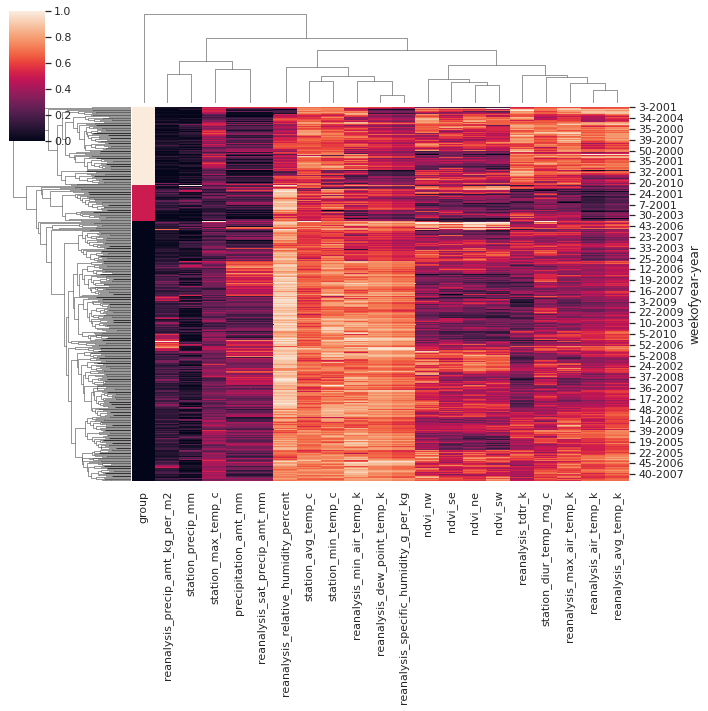

In [ ]:
# https://seaborn.pydata.org/generated/seaborn.clustermap.html
sns.clustermap(data_train_iq, standard_scale=1)

# Clústering con Kmeans 

Vamos a usar este algoritmo donde se van a establecer un número de centroides (grupos) que se inicializaránde forma aleatoria. Comenzaremos estableciendo los parámetros para inicializar el algoritmo.

Trabajaremos en esta ocasión con los datos proyectados sobre las componentes principales (PCA)


## Parametrización

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# Parámetros

# inicialización aleatoria
init = "random"

# Selecciona el mejor modelo de entre 10 ejecuciones diferentes
iterations = 10

# número máximo número de iteraciones por cada ejecución
max_iter = 300 

# Controla la tolerancia del SSE intercluster para establecer convergencia
tol = 1e-04 

# establecemos la semilla
random_state = 0

Eligiremos K en función de los valores de Distorsión (SSE) y Silhouette (rango K = 2 hasta K = 11)

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics

distortions = []
silhouettes = []

for i in range(2, 11):
    km = KMeans(i, init, n_init = iterations ,max_iter= max_iter, tol = tol,random_state = random_state)
    labels = km.fit_predict(pca_train_data)
    distortions.append(km.inertia_)
    silhouettes.append(metrics.silhouette_score(pca_train_data, labels))

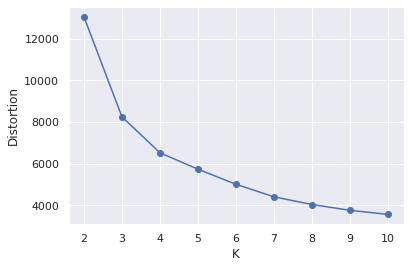

In [ ]:
plt.plot(range(2,11), distortions, marker='o')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.show()

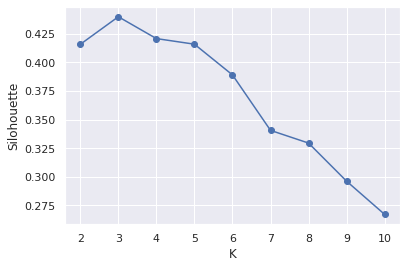

In [ ]:
plt.plot(range(2,11), silhouettes , marker='o')
plt.xlabel('K')
plt.ylabel('Silohouette')
plt.show()

Como vemos el K que mejor coeficiente de Silhouette es K=3, sin embargo, obtenemos elevados valores para la distorisión incluso para números de K altos.

## Ejecución del algoritmo

In [ ]:
# Elegimos que nos separe los datos en 4 clústeres
k = 4

# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
km = KMeans(k, init, n_init = iterations ,
            max_iter= max_iter, tol = tol, random_state = random_state)

# Usamos los datos de la PCA 
y_km = km.fit_predict(pca_train_data)

In [ ]:
from sklearn import metrics
# Distorsión y oeficiente de Silhouette 

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(scaled_train_data, y_km))
      
print('Distortion: %.2f' % km.inertia_)

Silhouette Coefficient: 0.295
Distortion: 6520.90


In [ ]:
km.labels_

array([3, 3, 1, ..., 0, 0, 2], dtype=int32)

## Visualización de los resultados

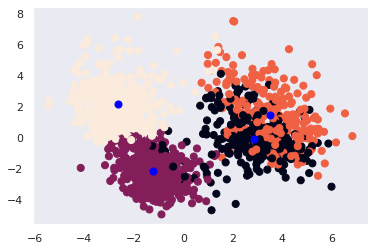

In [ ]:
# Gráfico de los puntos con colores en función de su etiqueta
plt.scatter(pca_train_data[:,0], pca_train_data[:,1], c=km.labels_,s=50)
# Se dibujan los centroides
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], c='blue',s=50)

plt.grid()
plt.show()

Como se aprecia en la gráfica, en los datos pertenecientes a San Juan (grupo de la izquierda) parece que el algoritmo ha conseguido separar dos grupos bien diferenciados. Sin embargo, para los datos pertenecientes a Iquitos (grupo de la derecha) el algoritmo no ha conseguido establecer una diferencia clara entre los grupos resultantes.

Vamos a ver como se distribuyen en los grupos obtenidos las características elegidas

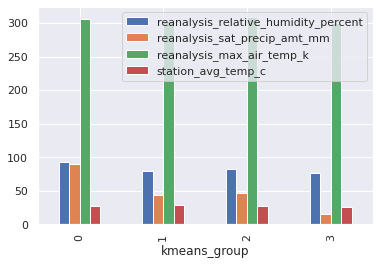

In [ ]:
# Añadimos las etiquetas como una nueva columna
data_train['kmeans_group'] = km.labels_

# Características que vamos a seleccionar
features = ["reanalysis_relative_humidity_percent","reanalysis_sat_precip_amt_mm",
            "reanalysis_max_air_temp_k","station_avg_temp_c","kmeans_group"]

# Los agrupamos por etiqueta y realizamos la media de las características
res = data_train[features].groupby(('kmeans_group')).mean()
res.plot(kind='bar', legend=True)

Como se observa, la característica en color verde aparece mucho en todos los grupos. La característica en azul y en rojo se encuentran casi igual distribuida en los cuatro grupos. La característica en naranja 

# Clustering con DBSCAN
Este algoritmo diferencia zonas de puntos densas de otras de baja densidad y con él buscaremos detectar aquellos puntos que pueden ser considerados como ruido dentro de los datos.

## Parametrización

Estableciendo un número mínimo de puntos vamos a ordenar la distancia de los puntos a su k-ésimo vecino y de esta manera comprobar, para un determinado $\epsilon$ el número de clústers. Con cada dato etiquetado podremos identificar cuales han sido considerados como ruido.

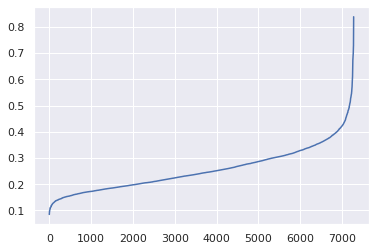

In [ ]:
# Número minimo de puntos para formarse un clúster
minPts=5

# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html
from sklearn.neighbors import kneighbors_graph
A = kneighbors_graph(minmax_scaled_data, minPts, include_self=False)
Ar = A.toarray()

# Añadimos a una lista aquellas distancias entre vecinos distintas de 0
seq = []
for i,s in enumerate(minmax_scaled_data):
    for j in range(len(minmax_scaled_data)):
        if Ar[i][j] != 0:
            seq.append(matsim[i][j])

# ordenamos las distancias      
seq.sort()

# Graficamos las distancias ordenadas
fig = plt.figure()
ax = fig.gca()
#ax.set_xticks(np.arange(0, 150, 20))
#ax.set_yticks(np.arange(0, 3, 0.2))

plt.plot(seq)


plt.show()

Las distancias comienza a crecer entorno a 0.4, por lo que vamos a coger un intervalo amplio y ver como el algoritmo clusteriza los datos para distintas epsilon.

## Ejecución

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
from sklearn.cluster import DBSCAN

# Rango de epsilon entre 0.2 y 0.55
for eps in np.arange(0.2, 0.6, 0.05):
  db = DBSCAN(eps, min_samples=minPts).fit(minmax_scaled_data)
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  print (eps, n_clusters_)

0.2 3
0.25 5
0.3 5
0.35 2
0.39999999999999997 2
0.44999999999999996 2
0.49999999999999994 2
0.5499999999999999 2


Viendo los resultados de la clusterización y tras varias pruebas he decidido tomar epsilon como 0.4. Las etiquetas para cada dato se obtienen.

In [ ]:
# Etiquetas para epsilon = 0.4
db = DBSCAN(eps=0.4, min_samples=minPts).fit(minmax_scaled_data)
labels = db.labels_
labels

array([0, 0, 0, ..., 1, 1, 1])

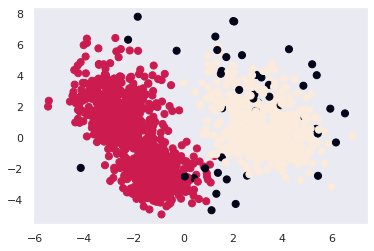

In [ ]:
# Graficamos los datos con colores que indican su etiqueta
plt.scatter(pca_train_data[:,0], pca_train_data[:,1], c=labels,s=50)
plt.grid()
plt.show()

Como se puede ver el algoritmo agrupa casi todos los registros para la ciudad de San Juan (izquierda) y muestra la presencia de ruido alrededor de los datos pertenecientes a Iquitos (derecha).

# Expectation-Maximization



En este tipo de algoritmos los clústeres quedan representados por una distribución gaussiana. Primero de todo vamos a comprobar cual es el mejor número de clústeres y qué parámetro de covarianza conviene usar.

In [ ]:
from sklearn.mixture import GaussianMixture

lowest_bic = np.infty
bic = []
best_cv = 'full'
best_k = 3
cv_types = ['spherical', 'tied', 'diag', 'full']
n_components_range = range(1, 7)
for cv_type in cv_types:
    for k in range(1, 7):
        gmm = GaussianMixture(n_components=k, covariance_type=cv_type, init_params='random')
        gmm.fit(pca_train_data)
        # GaussianMixture.bic --> Bayesian information criterion for the current model on the input X.
        bic.append(gmm.bic(pca_train_data))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_cv = cv_type
            best_k = k
            
print ("Mejor valor K", best_k, "Mejor tipo de Covarianza", best_cv)

Mejor valor K 6 Mejor tipo de Covarianza full


Obtenemos que el mejor valor de K son 6 clústeres y el parámetro de covarianza "full"

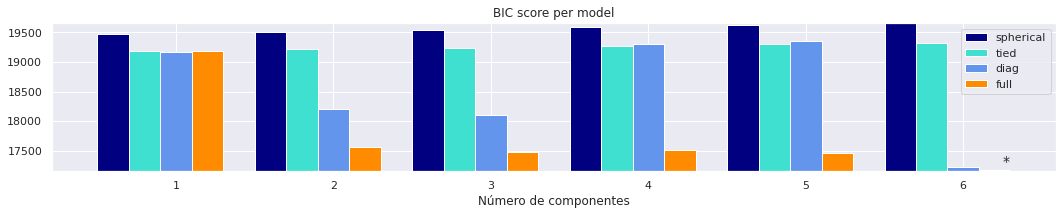

In [ ]:
# Plot the BIC scores
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
# Gráfico de barras con los valores BIC obtenidos
bars = []
plt.figure(figsize=(18, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([min(bic) * 1.01 - .01 * max(bic), max(bic)])
plt.title('BIC score per model')
xpos = np.mod(np.argmin(bic), len(n_components_range)) + .65 +\
    .2 * np.floor(np.argmin(bic) / len(n_components_range))
plt.text(xpos, min(bic) * 0.97 + .03 * max(bic), '*', fontsize=14)
spl.set_xlabel('Número de componentes')
spl.legend([b[0] for b in bars], cv_types)

Ejecutamos el algoritmo con los mejores parámetros

In [ ]:
EM = GaussianMixture(n_components=best_k, covariance_type=best_cv, init_params='random')
EM.fit(pca_train_data)
labels =  EM.predict(pca_train_data)
n_clusters = best_k - (1 if -1 in labels else 0)

Visualizamos los resultados

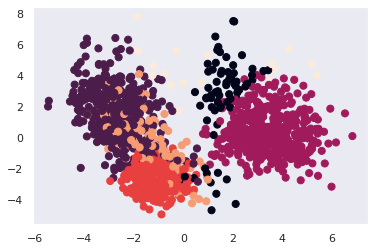

In [ ]:
plt.scatter(pca_train_data[:,0], pca_train_data[:,1], c=labels,s=50)
plt.grid()
plt.show()

Observamos de nuevo que para los datos de San Juan (izquierda) nos separa en tres grupos. Dos de ellos se asemejan a la clusterización realizada por K-means. Para Iquitos (derecha) obtenemos un gran clúster y otros dos mas pequeños (negro y blanco) pudiendo asociarse a ruido el blanco.

Las características en estos grupos se distribuyen de la siguiente forma

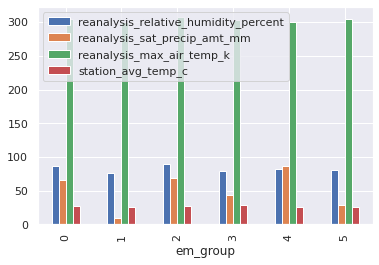

In [ ]:
# Añadimos al dataframe las etiquetas obtenidas
data_train['em_group'] = labels

# lista de características
res = data_train[["reanalysis_relative_humidity_percent","reanalysis_sat_precip_amt_mm",
            "reanalysis_max_air_temp_k","station_avg_temp_c", "em_group"]].groupby(('em_group')).mean()

# Graficamos
res.plot(kind='bar', legend=True)

La distribución de las características parece muy similar a la obtenida con el K-means

# Conclusiones
La PCA ha conseguido reducir la dimensionalidad de las variables, sin embargo, la cantidad de varianza explicada por eje no es muy alta.

De entre las veinte características que forman este dataset se ha elegido, en primera instancia, cuatro en base a los resultados provistos por los algoritmos y la PCA.

De los datos se observan dos grandes grupos pertenecientes a cada una de las ciudades. Los resultados del clústering de estos datos sugieren que puede haber dos subgrupos para la ciudad de San Juan y solo uno para la de Iquitos. Para esta última ciudad encontramos que la clusterización no es muy buena y puede ser debido a la presencia de ruido como muestran los algoritmos de DBSCAN y Expectation-Maximization.

En general, los estimadores de calidad no han sido muy buenos. Quizás una segunda iteración modificando los posibles outliers diera mejores resultados.